<a href="https://colab.research.google.com/github/fatehOurghi/face-detection-evaluation/blob/main/notebook_FD_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of face detection algorithms

This colab notebook will be used to evaluate different face detection algorithms including:
1.   TinaFace (best of Wider Face)
2.   DSFD (best of FDDB)
3.   SRN (best of Pascal Face)
---
Datasets used in this evaluation are:
*   Wider Face
*   FDDB
*   Pascal Face

**Machine configurations**

# Mount google drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets Preparation

**Extract downloaded *Wider face* dataset**

In [ ]:
# Extract train data
import zipfile
dataset_path = "/content/drive/MyDrive/Datasets/FaceDetection/WiderFace/WIDER_train.zip"
unzip_to = "/content/drive/MyDrive/Datasets/WIDER_train"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_to)

In [ ]:
# Extract test data
import zipfile
dataset_path = "/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/WIDER_test.zip"
unzip_to = "/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/test"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_to)

In [ ]:
# Download dataset face annotations
!wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip

In [ ]:
# extract annotations
!unzip -q /content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/wider_face_split.zip

**Download of FDDB dataset**

In [ ]:
!wget http://vis-www.cs.umass.edu/fddb/originalPics.tar.gz

In [ ]:
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz

**Extract FDDB dataset**




In [ ]:
# extract dataset
!tar -zxvf /content/drive/MyDrive/Datasets/FaceDetection/PascalFace/caltech.tar.gz

In [ ]:
# extract annotations
!tar -zxvf /content/drive/MyDrive/Datasets/FaceDetection/FDDB/FDDB-folds.tgz

**Extract FDDB dataset**

In [ ]:
!tar -zxvf /content/drive/MyDrive/Datasets/FaceDetection/FDDB/originalPics.tar.gz

**Download the Pascal Face dataset**

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/download/caltech.tar.gz

# Load dataset

In [36]:
import cv2
from google.colab.patches import cv2_imshow

In [13]:
ROOT = '/content/drive/MyDrive/Datasets/FaceDetection/'
import os
import json
#default: load rectangles list
def load_annotations(path, atype='rectangle'):
  filenames = []
  annotations = []
  for filename in os.listdir(path):
    if filename.__contains__(atype):
      filenames.append(filename)
  for filename in filenames:
    raw = open(path + filename)
    doc = {
        'annotations_filename': filename,
        'annotations': json.loads(raw.read())
    }
    annotations.append(doc)
    
  return annotations



**Load WiderFace**

In [24]:
DATASET = "WIDERFace"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"


**TinaFace**

**DSFD**

**SRN**

**Load FDDB**

In [37]:
DATASET = "FDDB"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"
annotations = load_annotations(test_path + "annotations/")
# img_path = test_path + annotations[0]['annotations'][0]['filename'] + '.jpg' # example img


**TinaFace**

**DSFD**

**SRN**

**Load Pascal Face**

In [14]:
DATASET = "PascalFace"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"
annotations = load_annotations(test_path + "annotations/")
print(annotations)

[{'annotations_filename': 'pascal-face-rectangleList.json', 'annotations': [{'filename': 'image_0001.png', 'count': 1, 'faces': [{'top_left': [433, 37], 'bottom_right': [784, 533], 'angle': 0}]}, {'filename': 'image_0002.png', 'count': 1, 'faces': [{'top_left': [189, 60], 'bottom_right': [534, 525], 'angle': 0}]}, {'filename': 'image_0003.png', 'count': 1, 'faces': [{'top_left': [350, 48], 'bottom_right': [714, 508], 'angle': 0}]}, {'filename': 'image_0004.png', 'count': 1, 'faces': [{'top_left': [173, 109], 'bottom_right': [505, 539], 'angle': 0}]}, {'filename': 'image_0005.png', 'count': 1, 'faces': [{'top_left': [414, 66], 'bottom_right': [753, 519], 'angle': 0}]}, {'filename': 'image_0006.png', 'count': 1, 'faces': [{'top_left': [425, 50], 'bottom_right': [774, 523], 'angle': 0}]}, {'filename': 'image_0007.png', 'count': 1, 'faces': [{'top_left': [284, 52], 'bottom_right': [613, 510], 'angle': 0}]}, {'filename': 'image_0008.png', 'count': 1, 'faces': [{'top_left': [371, 87], 'botto

**TinaFace**

In [16]:
# load model
import torch
tinaface_path = "/content/drive/MyDrive/Models/FaceDetection/Tinaface_r50_fpn_widerface.pth"
model = torch.load(tinaface_path)
print(model.)

OrderedDict([('backbone.conv1.weight', tensor([[[[-0.0220, -0.0027,  0.0077,  ...,  0.0134,  0.0034, -0.0127],
          [-0.0165, -0.0104, -0.0030,  ...,  0.0363,  0.0231, -0.0022],
          [-0.0123, -0.0182, -0.0336,  ...,  0.0059,  0.0271,  0.0245],
          ...,
          [ 0.0018,  0.0164,  0.0177,  ..., -0.0502, -0.0529, -0.0110],
          [ 0.0073,  0.0173,  0.0300,  ...,  0.0092, -0.0120,  0.0008],
          [ 0.0113,  0.0170,  0.0176,  ...,  0.0298,  0.0214,  0.0320]],

         [[-0.0010,  0.0062,  0.0071,  ..., -0.0020, -0.0074, -0.0131],
          [ 0.0019, -0.0029, -0.0036,  ...,  0.0217,  0.0124, -0.0059],
          [ 0.0071, -0.0081, -0.0304,  ..., -0.0023,  0.0220,  0.0232],
          ...,
          [ 0.0012,  0.0058,  0.0005,  ..., -0.0709, -0.0680, -0.0219],
          [-0.0012, -0.0042,  0.0002,  ..., -0.0236, -0.0354, -0.0171],
          [-0.0033, -0.0137, -0.0216,  ..., -0.0125, -0.0101,  0.0084]],

         [[-0.0115, -0.0011,  0.0044,  ...,  0.0021, -0.0041, -

**DSFD**

In [2]:
# install face_detection framework
!pip install face-detection

  Created wheel for face-detection: filename=face_detection-0.2.1-cp37-none-any.whl size=21404 sha256=705f48de55fd4d2401d4675daf614ff33f46570115f0e792ced8f1d52bfefb4e
  Stored in directory: /root/.cache/pip/wheels/7d/45/54/d117d6cc260f31a22d15cda860ff46325af314cac687848ab7
Successfully built face-detection


time:  -20.080644607543945


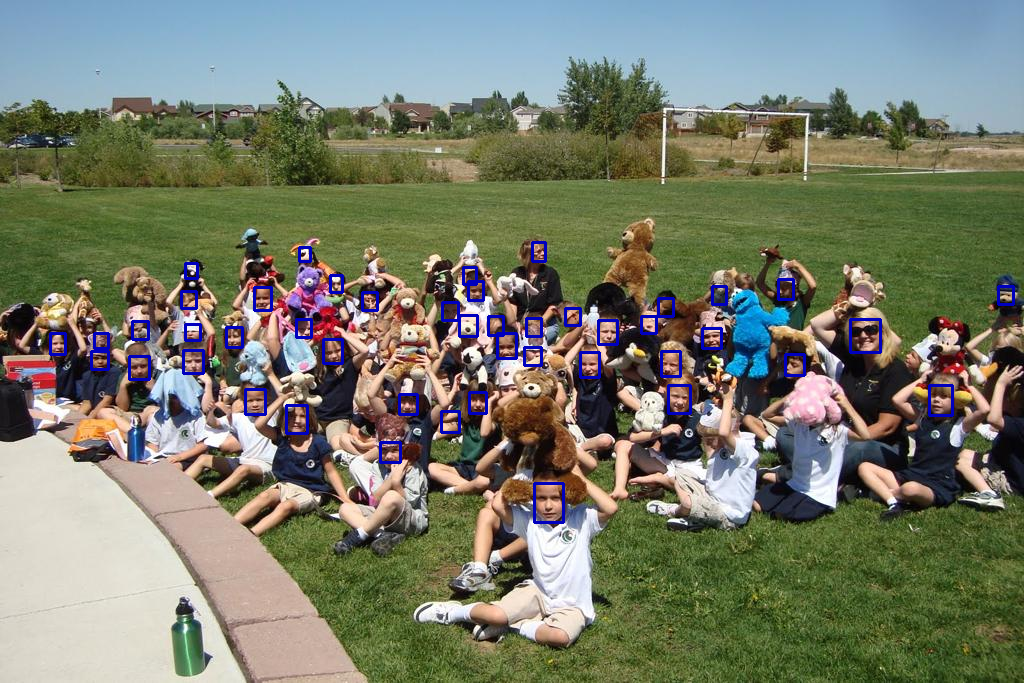

In [11]:
import cv2
import face_detection
import time
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)
# BGR to RGB
im = cv2.imread("/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/test/images/22--Picnic/22_Picnic_Picnic_22_106.jpg")
start = time.time()
detections = detector.detect(im)
for rectangle in detections:
  i = cv2.rectangle(im, (int(rectangle[0]), int(rectangle[1])), (int(rectangle[2]), int(rectangle[3])), (190,0,0), 2)
print("time: ", start - time.time())
from google.colab.patches import cv2_imshow
cv2_imshow(i)

**SRN**